# Notebook to run Annotation Human Heart to Mouse Heart - Lymphoid

**Created by** : Srivalli Kolla

**Created on** : 2 October, 2024

**Modified on** : 4 October, 2024

**Institute of Systems Immunology, University of Würzburg**

Env : scvi-env

# Import Packages

In [840]:
import scvi
import torch
import anndata
import warnings
import time
import datetime
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
import scib_metrics
import scib
import faiss
import matplotlib.pyplot as plt

from scib_metrics.nearest_neighbors import NeighborsResults
from pywaffle import Waffle
from scib_metrics.benchmark import Benchmarker, BioConservation

In [841]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

timestamp = datetime.datetime.now().strftime("%d_%m_%y")

-----
anndata     0.10.8
scanpy      1.10.2
-----
Cython              3.0.11
PIL                 10.3.0
absl                NA
array_api_compat    1.7.1
asttokens           NA
attr                23.2.0
chex                0.1.86
colorama            0.4.6
comm                0.2.2
contextlib2         NA
cycler              0.12.1
cython              3.0.11
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
deprecated          1.2.14
django              5.0.6
docrep              0.3.2
etils               1.9.2
executing           2.0.1
faiss               1.8.0
filelock            3.15.4
flax                0.8.5
fsspec              2024.6.1
h5py                3.11.0
igraph              0.11.6
importlib_resources NA
ipykernel           6.29.5
ipywidgets          8.1.5
jax                 0.4.30
jaxlib              0.4.30
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg

In [842]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [843]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)


# Import Data

## Reference

In [844]:
ref_all = sc.read_h5ad('../../data/Global_raw.h5ad')
ref_all

AnnData object with n_obs × n_vars = 704296 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_t

In [845]:
ref_all.obs['region_finest'].value_counts()

region_finest
LV                   130304
AX                   102221
RV                    92403
SP                    88911
LA                    74501
RA                    55060
SAN                   31227
AVN                   28024
na                    23769
AVN SEPT LAT          11753
IVS MID LV             8995
LV FW ANTLAT ENDO      8274
RV FW ENDO             7949
SAN CAUD CRAN          5519
LV APEX ENDO           4905
AVN MID LAT            4844
RV FW EPI              4102
LV FW ANTLAT EPI       4039
SAN CRAN CAUD          3560
SAN MID CAUD           3482
RAA                    2435
AVN SEPT SEPT          1786
AVN LAT SEPT           1567
IVS MID RV             1118
AVN MID SEPT           1045
SAN MID CRAN           1011
LV APEX EPI             907
SAN MID                 585
Name: count, dtype: int64

In [846]:
ref_all.obs['cell_or_nuclei'].value_counts()

cell_or_nuclei
Nuclei    568598
Cell      135698
Name: count, dtype: int64

In [847]:
ref_all.obs['cell_type'].value_counts()

cell_type
Ventricular Cardiomyocyte     190710
Fibroblast                    138055
Endothelial cell              131505
Mural cell                    104593
Myeloid                        51426
Atrial Cardiomyocyte           45911
Lymphoid                       24922
Neural cell                     6622
Adipocyte                       6347
Mast cell                       1853
Lymphatic Endothelial cell      1295
Mesothelial cell                1057
Name: count, dtype: int64

### Subsetting data

In [848]:
ref = ref_all[(ref_all.obs['region_finest'] == 'LV') & (ref_all.obs['cell_type'] == 'Lymphoid') & (ref_all.obs['cell_or_nuclei'] == 'Nuclei')]
ref

View of AnnData object with n_obs × n_vars = 857 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'do

In [849]:
ref.obs['cell_state'].value_counts()

cell_state
CD8+T_trans     184
NK_CD56hi       124
CD8+T_em         89
NK_CD16hi        82
CD4+T_naive      76
CD8+T_te         67
CD4+T_act        66
unclassified     60
CD8+T_cytox      31
B                27
MAIT-like        17
B_plasma         12
ILC              10
CD4+T_Th1         4
CD4+T_reg         4
CD4+T_Tfh         2
CD4+T_Th2         1
CD4+T_Th17        1
Name: count, dtype: int64

In [850]:
ref.obs['region_finest'].value_counts()

region_finest
LV    857
Name: count, dtype: int64

In [851]:
ref.obs['cell_or_nuclei'].value_counts()

cell_or_nuclei
Nuclei    857
Name: count, dtype: int64

In [852]:
ref.obs['facility'].value_counts()

facility
Harvard    546
Sanger     311
Name: count, dtype: int64

In [853]:
ref = ref[ref.obs['cell_state']!= 'unclassified']
ref

View of AnnData object with n_obs × n_vars = 797 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'do

In [854]:
ref.obs['cell_state'].value_counts()

cell_state
CD8+T_trans    184
NK_CD56hi      124
CD8+T_em        89
NK_CD16hi       82
CD4+T_naive     76
CD8+T_te        67
CD4+T_act       66
CD8+T_cytox     31
B               27
MAIT-like       17
B_plasma        12
ILC             10
CD4+T_Th1        4
CD4+T_reg        4
CD4+T_Tfh        2
CD4+T_Th2        1
CD4+T_Th17       1
Name: count, dtype: int64

In [855]:
ref.obs['sample'] = ref.obs['donor'].copy()

In [856]:
ref.obs['seed_labels'] = ref.obs['cell_state'].copy()
ref.obs['seed_labels'].value_counts()
ref.obs['seed_labels'].cat.categories

Index(['CD4+T_naive', 'CD4+T_act', 'CD4+T_Th1', 'CD4+T_Th2', 'CD4+T_Th17',
       'CD4+T_Tfh', 'CD4+T_reg', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te',
       'CD8+T_trans', 'MAIT-like', 'NK_CD16hi', 'NK_CD56hi', 'ILC', 'B',
       'B_plasma'],
      dtype='object')

In [857]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [858]:
print(X_is_raw(ref))

True


In [859]:
ref.layers['raw_counts'] = ref.X
ref

AnnData object with n_obs × n_vars = 797 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'd

In [860]:
sc.pp.filter_cells(ref, min_genes = 200)
sc.pp.filter_cells(ref, min_counts = 100)
ref

AnnData object with n_obs × n_vars = 797 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'd

In [861]:
sc.pp.highly_variable_genes(ref,    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "raw_counts",
    batch_key = "sample", span= 1 , subset= True )

ref

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 797 × 8000
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_

## Query

In [862]:
query_all = sc.read_h5ad('../../data/dmd_annotated_human_wt_all_celltypes_06_10_24.h5ad')
query_all

AnnData object with n_obs × n_vars = 61606 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_count

In [863]:
query_all.obs['cell_type'].value_counts()

cell_type
Ventricular Cardiomyocyte     56560
Endothelial cell               2811
Fibroblast                     1008
Myeloid                         658
Mural cell                      347
Lymphoid                        189
Neural cell                      14
Lymphatic Endothelial cell       12
Adipocyte                         4
Mast cell                         2
Mesothelial cell                  1
Name: count, dtype: int64

### Subsetting data

In [864]:
query = query_all[query_all.obs['cell_type'] == 'Lymphoid']
query

View of AnnData object with n_obs × n_vars = 189 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by

In [865]:
query.obs['seed_labels'] = 'Unknown'

In [866]:
print (X_is_raw(query))

False


In [867]:
query.X = query.layers['raw_counts']

In [868]:
print (X_is_raw(query))

True


In [869]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)
query

AnnData object with n_obs × n_vars = 189 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts'

### Checking vars

In [870]:
query.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Xkr4,False,False,2530,0.043516,98.656214,8193
Gm1992,False,False,300,0.002071,99.840658,390
Gm19938,False,False,317,0.001859,99.831628,350
Gm37381,False,False,72,0.000600,99.961758,113
Rp1,False,False,892,0.009895,99.526222,1863
...,...,...,...,...,...,...
Ac124606.1,False,False,0,0.000000,100.000000,0
Ac133095.2,False,False,0,0.000000,100.000000,0
Ac133095.1,False,False,0,0.000000,100.000000,0
Ac234645.1,False,False,0,0.000000,100.000000,0


In [871]:
ref.var

,gene_name-new,gene_name_scRNA-0-original,gene_name_snRNA-1-original,gene_name_multiome-2-original,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
ENSG00000237613,FAM138A,FAM138A,FAM138A,FAM138A,True,1499.0,0.000000,0.000000,0.000000,3
ENSG00000187608,ISG15,ISG15,ISG15,ISG15,True,2746.0,0.012547,0.014918,0.367458,10
ENSG00000160087,UBE2J2,UBE2J2,UBE2J2,UBE2J2,True,2885.0,0.042660,0.048429,0.785760,9
ENSG00000230415,LINC01786,LINC01786,LINC01786,LINC01786,True,3068.0,0.003764,0.003755,0.213472,3
ENSG00000169972,PUSL1,PUSL1,PUSL1,PUSL1,True,3025.0,0.003764,0.003755,0.213385,3
...,...,...,...,...,...,...,...,...,...,...
ENSG00000198840,MT-ND3,MT-ND3,MT-ND3,MT-ND3,True,1336.0,0.340025,0.583986,0.863436,11
ENSG00000198886,MT-ND4,MT-ND4,MT-ND4,MT-ND4,True,1394.0,0.376412,0.948589,1.076358,12
ENSG00000198727,MT-CYB,MT-CYB,MT-CYB,MT-CYB,True,2386.0,0.590966,1.116401,0.922984,12
ENSG00000276256,AC011043.1,AC011043.1,AC011043.1,AC011043.1,True,2883.0,0.001255,0.001255,0.071247,1


In [872]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [873]:
ref.var.index = ref.var['gene_name_snRNA-1-original'].astype(object)
ref.var_names

Index(['FAM138A', 'ISG15', 'UBE2J2', 'LINC01786', 'PUSL1', 'TAS1R3', 'CCNL2',
       'AL645728.1', 'FO704657.1', 'SLC35E2B',
       ...
       'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4',
       'MT-CYB', 'AC011043.1', 'AC240274.1'],
      dtype='object', name='gene_name_snRNA-1-original', length=8000)

# Data concatenation

#### Checking for duplicates

In [874]:
ref.var_names_make_unique()

In [875]:
adata = ref.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner' )
adata

AnnData object with n_obs × n_vars = 986 × 5235
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query', 'n_cells

In [876]:
adata.var

,mt-query,ribo-query,n_cells_by_counts-query,mean_counts-query,pct_dropout_by_counts-query,total_counts-query,gene_name-new-reference,gene_name_scRNA-0-original-reference,gene_name_snRNA-1-original-reference,gene_name_multiome-2-original-reference,highly_variable-reference,highly_variable_rank-reference,means-reference,variances-reference,variances_norm-reference,highly_variable_nbatches-reference
ISG15,False,False,1928,0.011696,98.975961,2202,ISG15,ISG15,ISG15,ISG15,True,2746.0,0.012547,0.014918,0.367458,10
UBE2J2,False,False,8693,0.054994,95.382793,10354,UBE2J2,UBE2J2,UBE2J2,UBE2J2,True,2885.0,0.042660,0.048429,0.785760,9
PUSL1,False,False,904,0.004950,99.519849,932,PUSL1,PUSL1,PUSL1,PUSL1,True,3025.0,0.003764,0.003755,0.213385,3
TAS1R3,False,False,124,0.000680,99.934139,128,TAS1R3,TAS1R3,TAS1R3,TAS1R3,True,2916.0,0.001255,0.001255,0.071247,1
CCNL2,False,False,21770,0.198891,88.437065,37446,CCNL2,CCNL2,CCNL2,CCNL2,True,2238.0,0.075282,0.079753,0.790661,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-CO2,True,False,171865,14.818424,8.715489,2789924,MT-CO2,MT-CO2,MT-CO2,MT-CO2,True,779.5,0.639900,1.768406,1.030953,12
MT-ATP6,True,False,171693,13.242498,8.806845,2493218,MT-ATP6,MT-ATP6,MT-ATP6,MT-ATP6,True,301.0,0.614806,2.088876,1.185685,11
MT-CO3,True,False,176406,20.557098,6.303579,3870367,MT-CO3,MT-CO3,MT-CO3,MT-CO3,True,586.0,0.774153,2.159984,1.090288,13
MT-ND3,True,False,153550,3.305810,18.443333,622398,MT-ND3,MT-ND3,MT-ND3,MT-ND3,True,1336.0,0.340025,0.583986,0.863436,11


In [877]:
adata.obs['seed_labels'].value_counts()

seed_labels
Unknown        189
CD8+T_trans    184
NK_CD56hi      124
CD8+T_em        89
NK_CD16hi       82
CD4+T_naive     76
CD8+T_te        67
CD4+T_act       66
CD8+T_cytox     31
B               27
MAIT-like       17
B_plasma        12
ILC             10
CD4+T_reg        4
CD4+T_Th1        4
CD4+T_Tfh        2
CD4+T_Th2        1
CD4+T_Th17       1
Name: count, dtype: int64

In [878]:
adata.obs['sample'].value_counts()

sample
H5       261
A10_2    152
H6        93
D7        85
H7        71
D8        70
D3        47
H4        43
A9_2      37
H2        35
D6        32
H3        23
D1        21
D2        10
D5         4
D11        2
Name: count, dtype: int64

In [879]:
adata.obs['batch'].value_counts()

batch
reference    797
query        189
Name: count, dtype: int64

In [880]:
adata.obs['region_finest'].value_counts()

region_finest
LV    797
Name: count, dtype: int64

In [881]:
adata.obs['cell_or_nuclei'].value_counts()

cell_or_nuclei
Nuclei    797
Name: count, dtype: int64

In [882]:
adata.obs['facility'].value_counts()

facility
Harvard    526
Sanger     271
Name: count, dtype: int64

In [883]:
print(X_is_raw(adata))

True


In [884]:
adata_raw = adata.copy()

In [885]:
adata.layers['raw_counts'] = adata.X.copy()

In [886]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "raw_counts",
    batch_key = "sample", span= 1, subset= True)

adata

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 986 × 5235
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query', 'n_cells

## PCA

In [887]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)


# SCVI

In [888]:
scvi.model.SCVI.setup_anndata(adata, 
                              labels_key = 'seed_labels',
                              layer = 'raw_counts',
                              categorical_covariate_keys = ['sample', 'batch'])
adata

AnnData object with n_obs × n_vars = 986 × 5235
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query', 'n_cells

In [889]:
model_scvi = scvi.model.SCVI(adata, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [890]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'raw_counts',
│   'batch_key': None,
│   'labels_key': 'seed_labels',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['sample', 'batch'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │  986  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  18   │
│          n_vars          │ 5235  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │         adata.layers['raw_counts']         │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['seed_labels'] │      B      │          0          │
│                          │  B_plasma   │          1          │
│                          │  CD4+T_Tfh  │          2          │
│                          │  CD4+T_Th1  │          3          │
│                          │ CD4+T_Th17  │          4          │
│                          │  CD4+T_Th2  │          5          │
│                          │  CD4+T_act  │          6          │
│                          │ CD4+T_naive │          7          │
│                          │  CD4+T_reg  │          8          │
│                          │ CD8+T_cytox │          9          │
│                          │  CD8+T_em   │         10          │
│                          │  CD8+T_te   │         11          │
│                          │ CD8+T_trans │         12          │
│                          │     ILC     │         13          │
│                          │  MAIT-like  │         14          │
│                          │  NK_CD16hi  │         15          │
│                          │  NK_CD56hi  │         16          │
│                          │   Unknown   │         17          │
└──────────────────────────┴─────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch']  │ reference  │          0          │
│                     │   query    │          1          │
│                     │            │                     │
│ adata.obs['sample'] │    A9_2    │          0          │
│                     │   A10_2    │          1          │
│                     │     D1     │          2          │
│                     │     D2     │          3          │
│                     │     D3     │          4          │
│                     │     D5     │          5          │
│                     │     D6     │          6          │
│                     │     D7     │          7          │
│                     │     D8     │          8          │
│                     │    D11     │          9          │
│                     │     H2     │         10          │
│                     │     H3     │         11          │
│                     │     H4     │         12          │
│                     │     H5     │         13          │
│                     │     H6     │         14          │
│                     │     H7     │         15          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [891]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

400

In [892]:
model_scvi.train(70,accelerator= 'gpu', devices= [1],check_val_every_n_epoch = 1, enable_progress_bar = True,)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 70/70: 100%|██████████| 70/70 [00:02<00:00, 24.96it/s, v_num=1, train_loss_step=935, train_loss_epoch=940]        

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 70/70: 100%|██████████| 70/70 [00:02<00:00, 24.94it/s, v_num=1, train_loss_step=935, train_loss_epoch=940]


In [893]:
model_scvi.save('./', overwrite=True, prefix= 'scvi')

## Evaluate model performance a la Sevensson

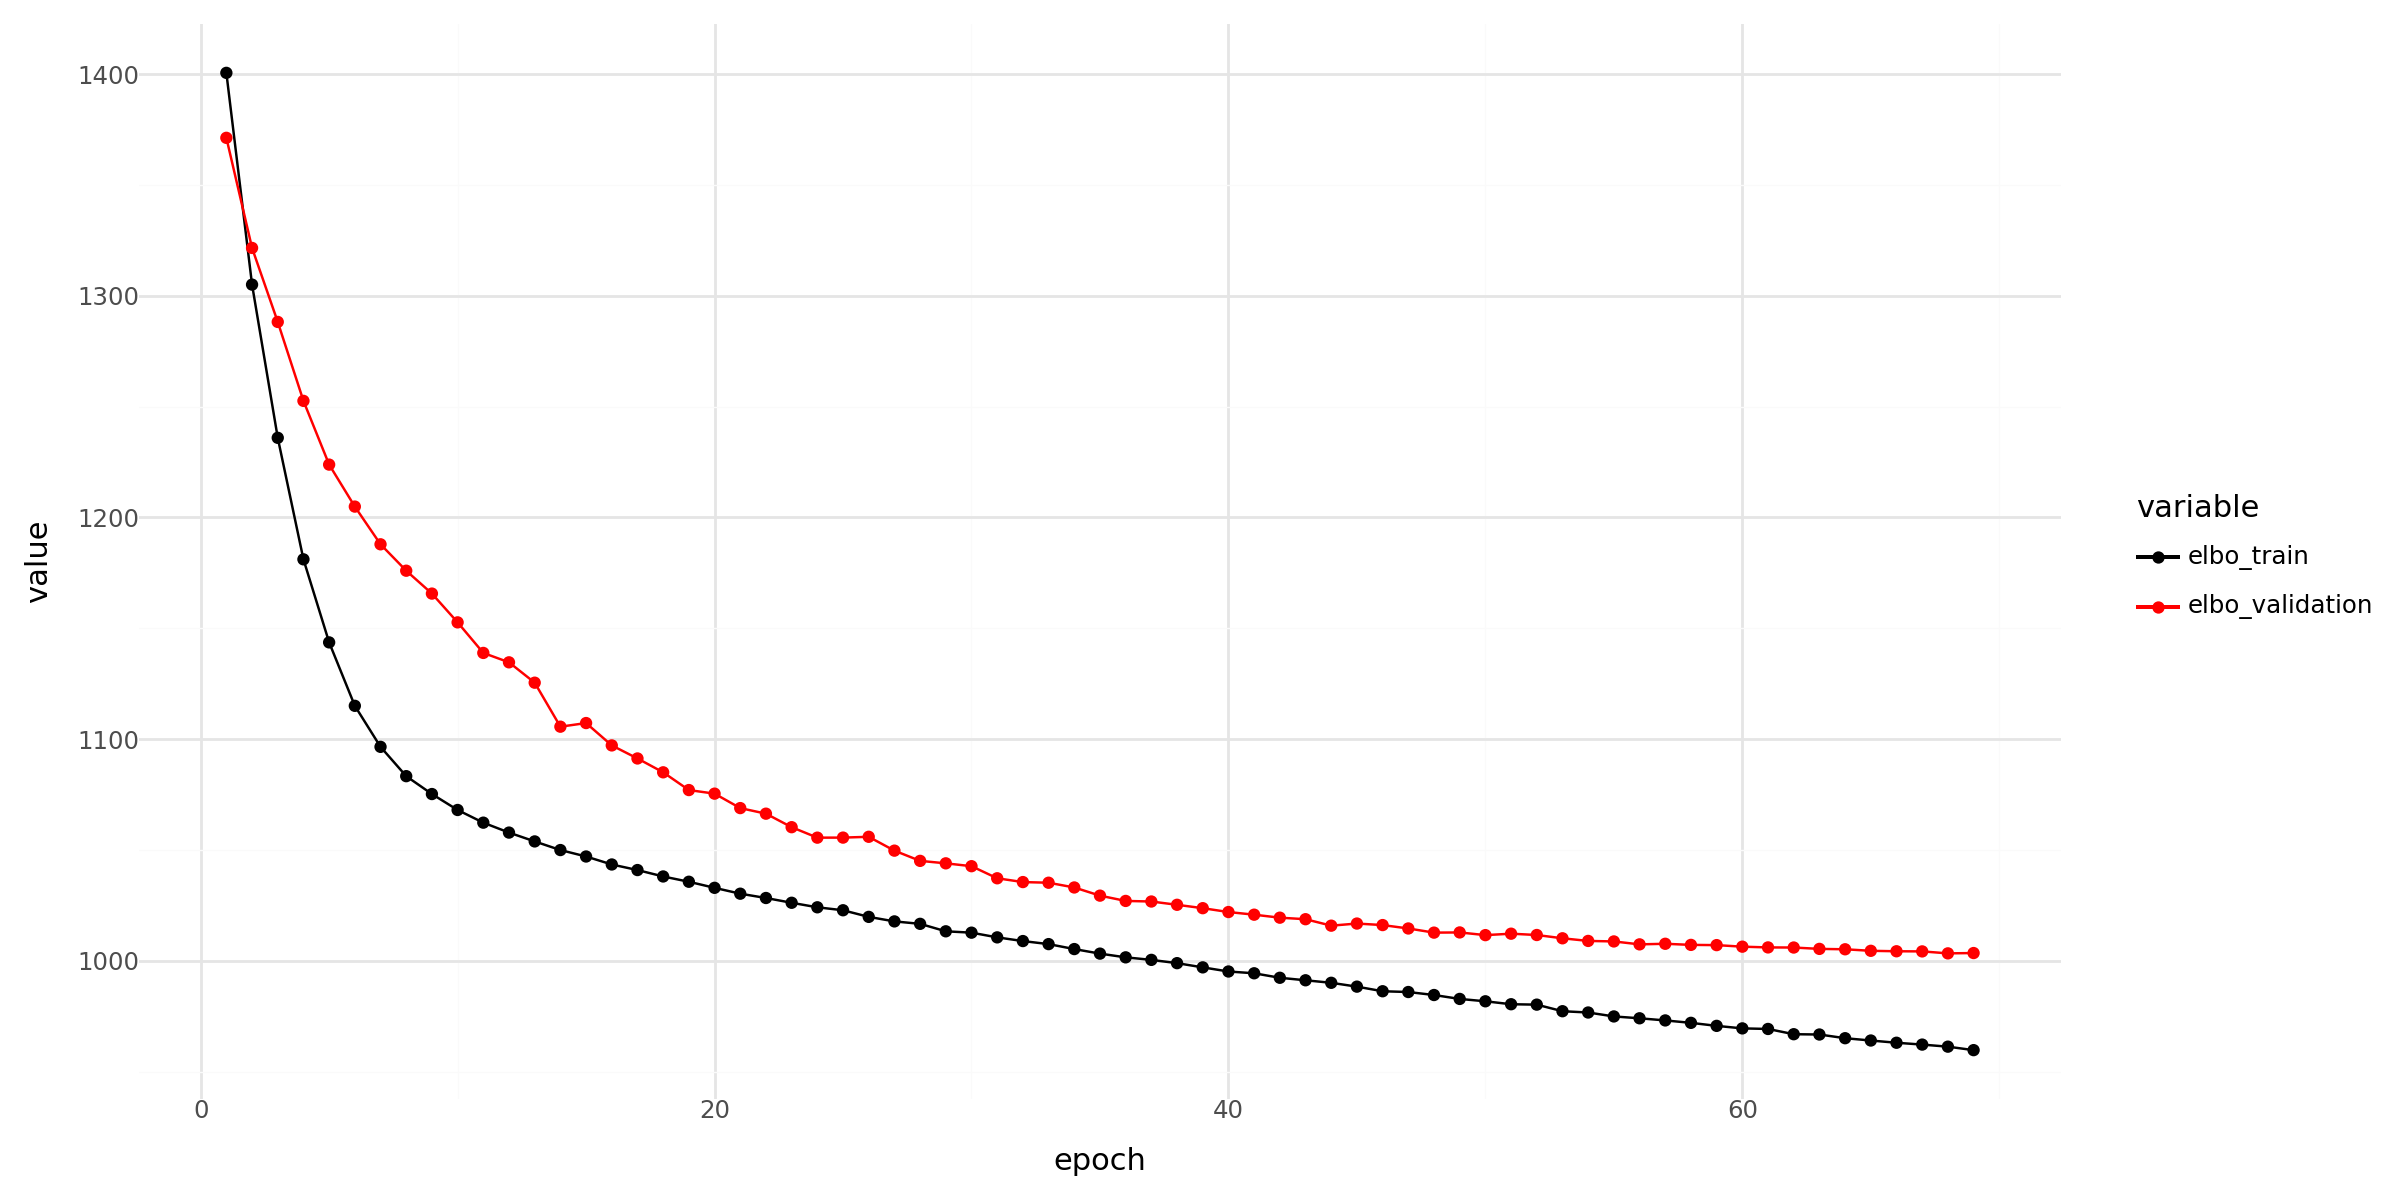

In [894]:
history_df = (
    model_scvi.history['elbo_train'].astype(float)
    .join(model_scvi.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('./scvi_la_sevensson.png', dpi = 300)

print(p_)

In [895]:
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [896]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
adata

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


AnnData object with n_obs × n_vars = 986 × 5235
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query', 'n_cells

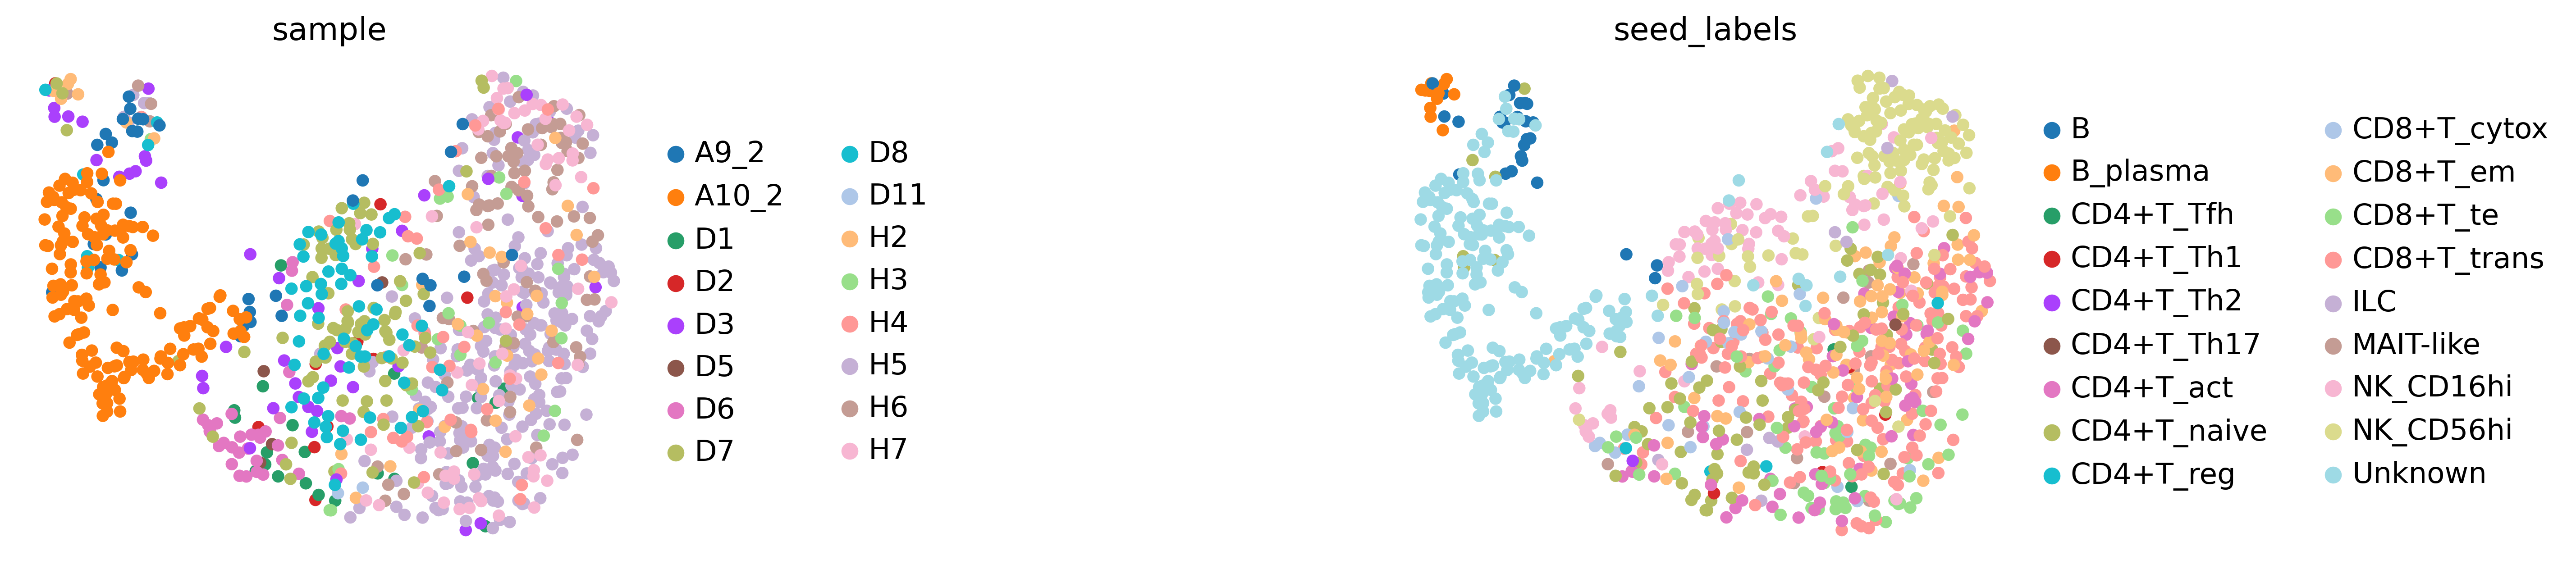

In [897]:
sc.pl.umap(adata, color=['sample', 'seed_labels'], wspace=1, frameon = False)

# scANVI

In [898]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(model_scvi,unlabeled_category= 'Unknown', labels_key= 'seed_labels')

In [899]:
model_scanvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'seed_labels',
│   'unlabeled_category': 'Unknown',
│   'layer': 'raw_counts',
│   'batch_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['sample', 'batch'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │  986  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  18   │
│          n_vars          │ 5235  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │         adata.layers['raw_counts']         │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['seed_labels'] │      B      │          0          │
│                          │  B_plasma   │          1          │
│                          │  CD4+T_Tfh  │          2          │
│                          │  CD4+T_Th1  │          3          │
│                          │  CD4+T_Th2  │          4          │
│                          │ CD4+T_Th17  │          5          │
│                          │  CD4+T_act  │          6          │
│                          │ CD4+T_naive │          7          │
│                          │  CD4+T_reg  │          8          │
│                          │ CD8+T_cytox │          9          │
│                          │  CD8+T_em   │         10          │
│                          │  CD8+T_te   │         11          │
│                          │ CD8+T_trans │         12          │
│                          │     ILC     │         13          │
│                          │  MAIT-like  │         14          │
│                          │  NK_CD16hi  │         15          │
│                          │  NK_CD56hi  │         16          │
│                          │   Unknown   │         17          │
└──────────────────────────┴─────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch']  │ reference  │          0          │
│                     │   query    │          1          │
│                     │            │                     │
│ adata.obs['sample'] │    A9_2    │          0          │
│                     │   A10_2    │          1          │
│                     │     D1     │          2          │
│                     │     D2     │          3          │
│                     │     D3     │          4          │
│                     │     D5     │          5          │
│                     │     D6     │          6          │
│                     │     D7     │          7          │
│                     │     D8     │          8          │
│                     │    D11     │          9          │
│                     │     H2     │         10          │
│                     │     H3     │         11          │
│                     │     H4     │         12          │
│                     │     H5     │         13          │
│                     │     H6     │         14          │
│                     │     H7     │         15          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [900]:
model_scanvi.train(50, devices= [1], accelerator= 'gpu',check_val_every_n_epoch = 1, enable_progress_bar = True, )

INFO     Training for 50 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 50/50: 100%|██████████| 50/50 [00:05<00:00,  9.26it/s, v_num=1, train_loss_step=898, train_loss_epoch=903]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:05<00:00,  9.96it/s, v_num=1, train_loss_step=898, train_loss_epoch=903]


In [901]:
model_scanvi.save('./', overwrite=True, prefix= 'scanvi')

In [902]:
adata.obsm["X_scANVI"] = model_scanvi.get_latent_representation()

## Evaluate model performance a la Svensson

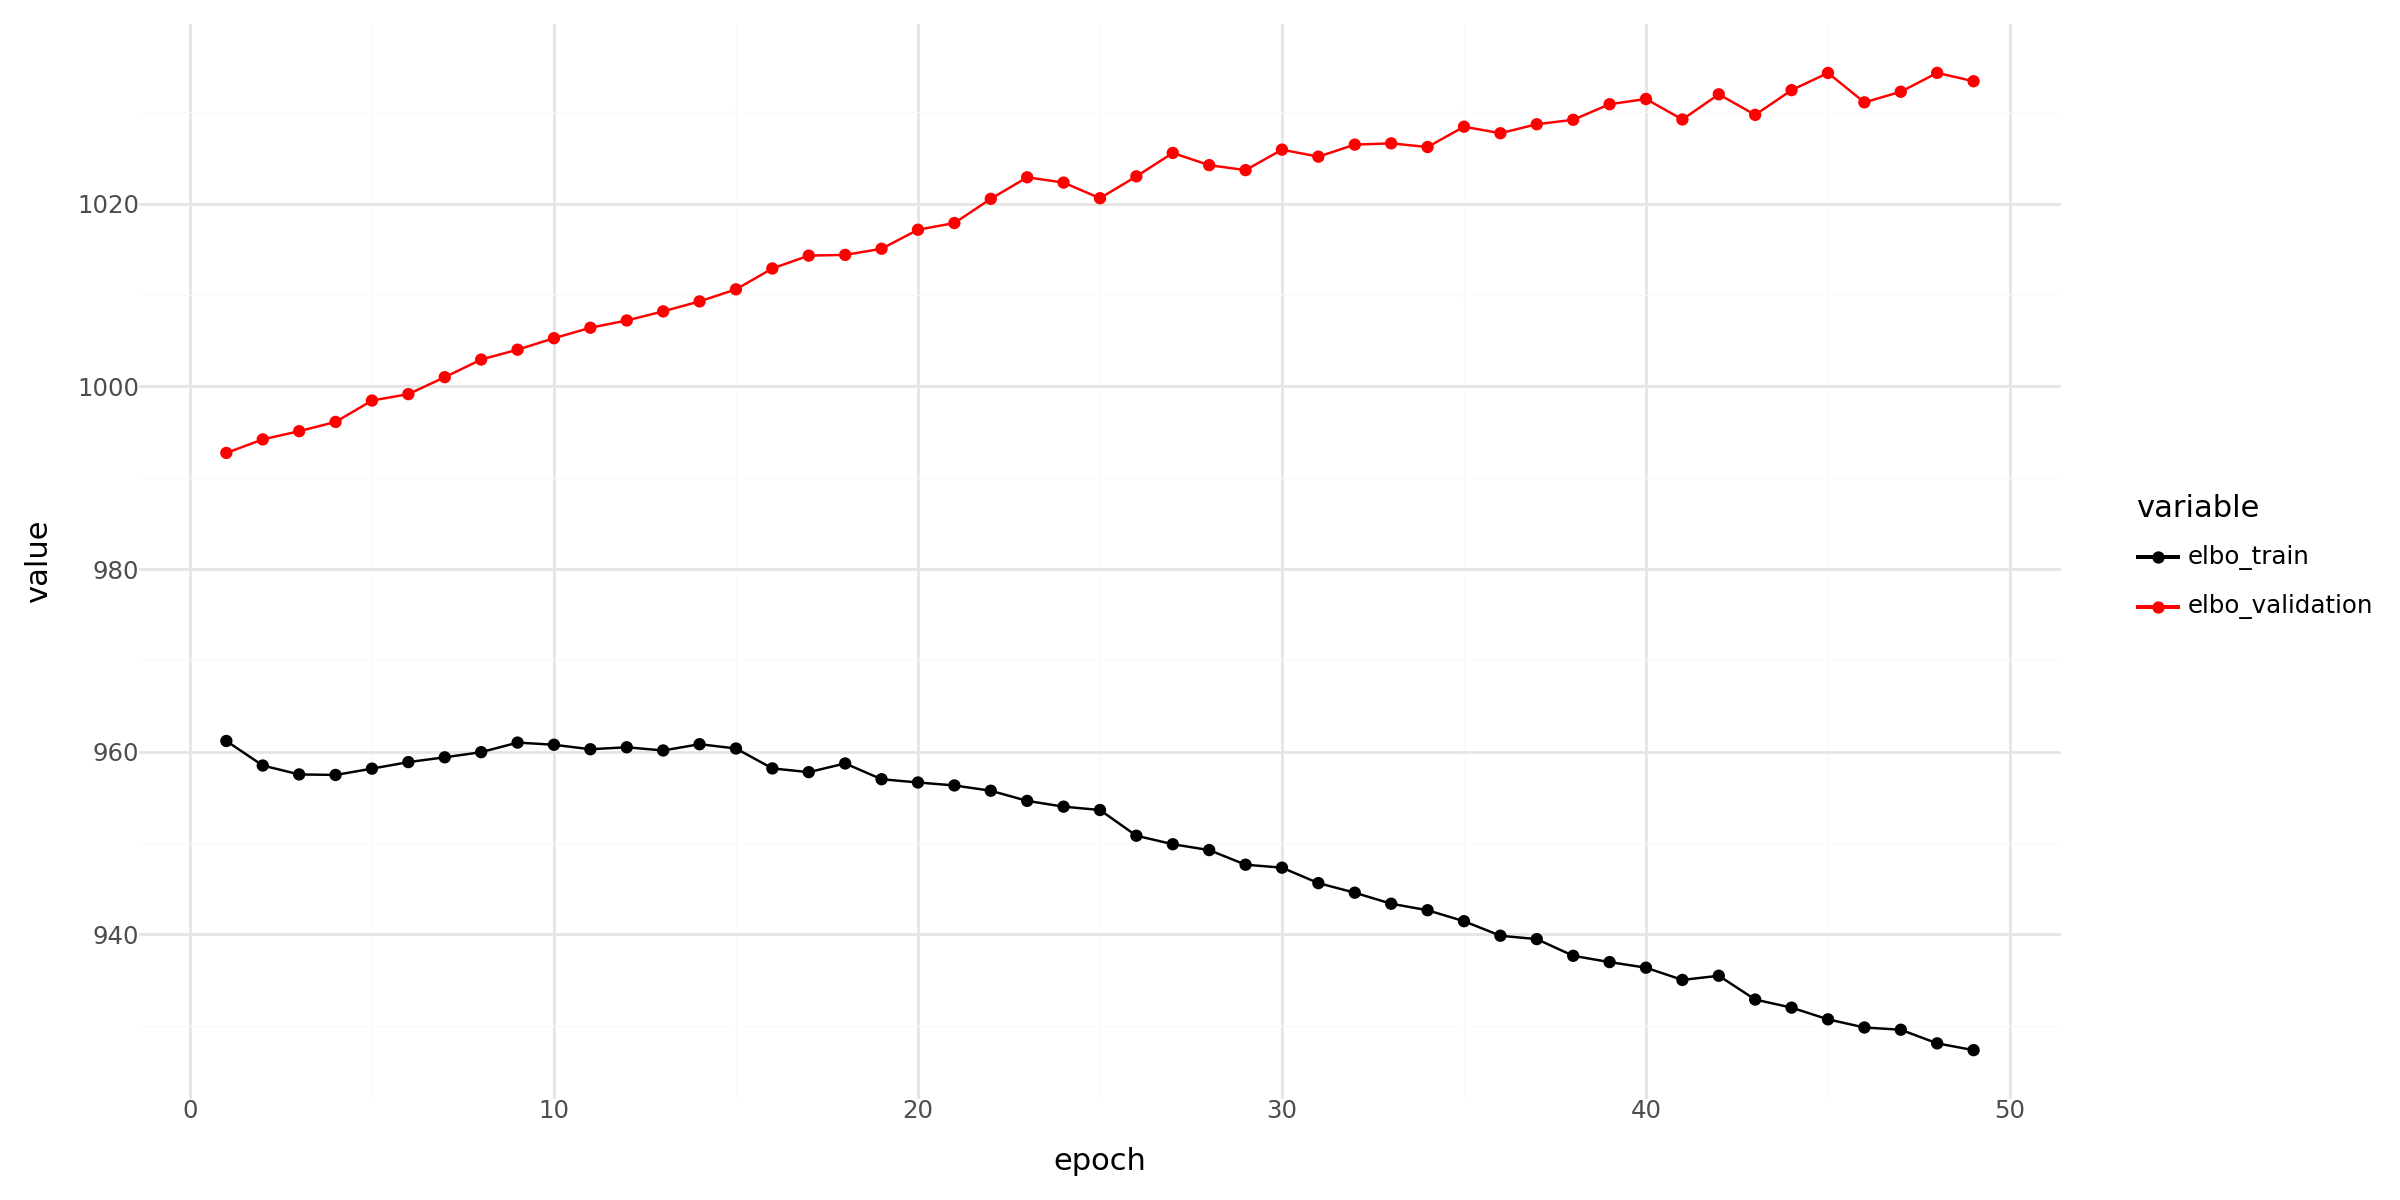

In [903]:
history_df = (
    model_scanvi.history['elbo_train'].astype(float)
    .join(model_scanvi.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('scanvi_la_sevensson.png', dpi = 300)

print(p_)

In [904]:
adata.obs["C_scANVI"] = model_scanvi.predict(adata)

In [905]:
adata.obsm["X_scANVI"] = model_scanvi.get_latent_representation(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


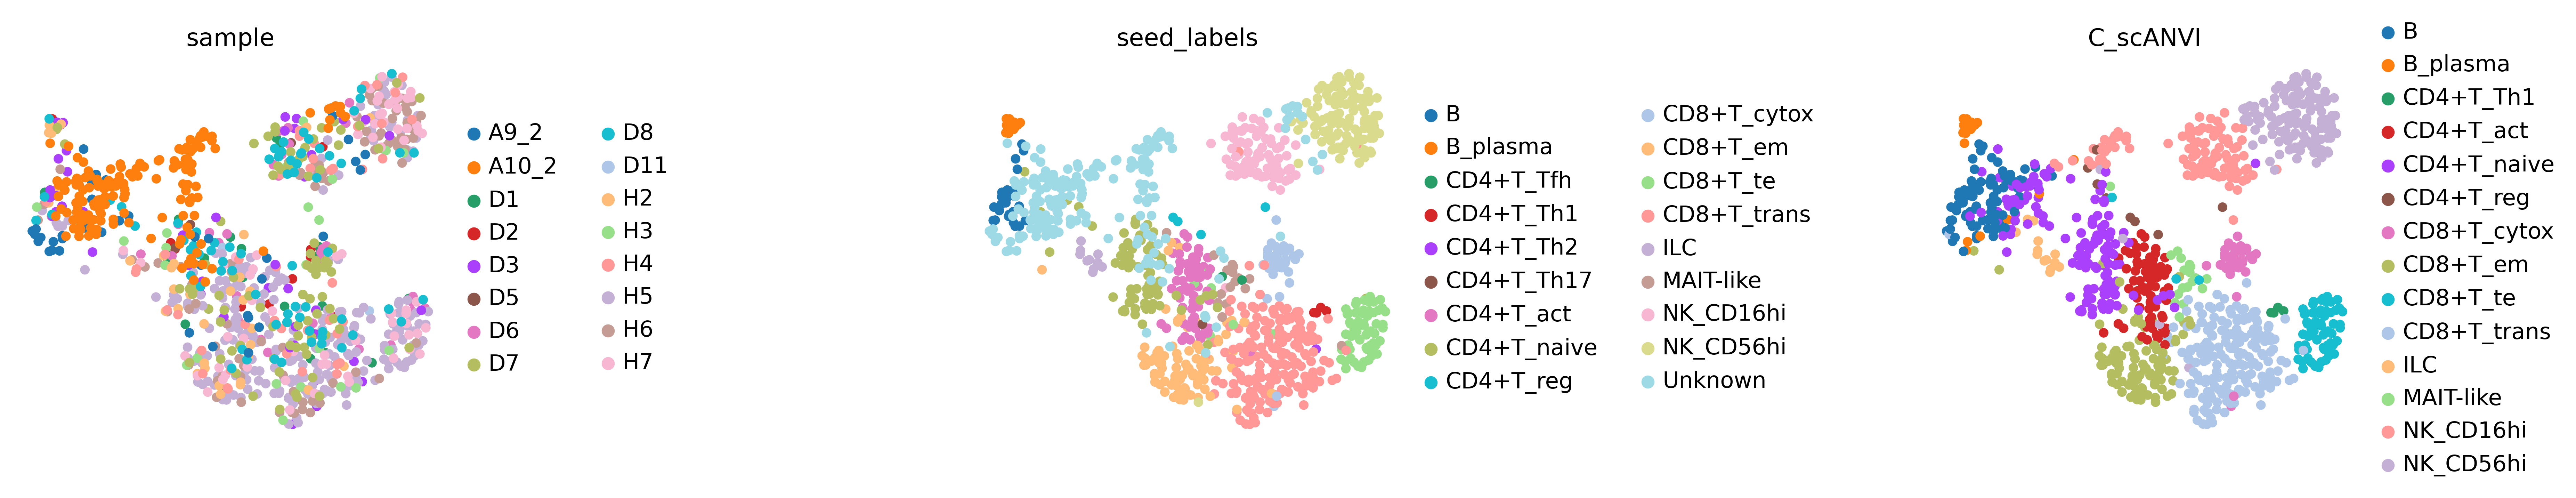

In [906]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color=['sample', 'seed_labels',"C_scANVI"], wspace=1, frameon = False)

# Export data

In [907]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

AnnData object with n_obs × n_vars = 986 × 5235
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query', 'n_cells

In [908]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

View of AnnData object with n_obs × n_vars = 189 × 5235
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query', 

In [909]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

AnnData object with n_obs × n_vars = 189 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts'

In [910]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [911]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
CD4+T_naive    61
B              54
NK_CD16hi      29
NK_CD56hi      14
B_plasma        7
CD8+T_em        5
CD4+T_act       4
CD4+T_reg       4
MAIT-like       3
ILC             3
CD8+T_te        2
CD8+T_trans     2
CD8+T_cytox     1
Name: count, dtype: int64

In [912]:
query_export.obs['cell_state'] = query_export.obs['C_scANVI'].copy()
#query_export.obs['cell_type'] = query_export.obs['cell_type'].replace('FB4_activated', 'FB4')
query_export

AnnData object with n_obs × n_vars = 189 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts'

In [913]:
query_export.obs['cell_state'] .value_counts()

cell_state
CD4+T_naive    61
B              54
NK_CD16hi      29
NK_CD56hi      14
B_plasma        7
CD8+T_em        5
CD4+T_act       4
CD4+T_reg       4
MAIT-like       3
ILC             3
CD8+T_te        2
CD8+T_trans     2
CD8+T_cytox     1
Name: count, dtype: int64

In [914]:
print(X_is_raw(query_export))

True


In [915]:
query_export.layers['raw_counts'] = query_export.X

In [916]:
sc.pp.normalize_total(query_export, target_sum= 1e6)
sc.pp.log1p(query_export)
query_export.layers['normalized'] = query_export.X

normalizing counts per cell
    finished (0:00:00)


computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


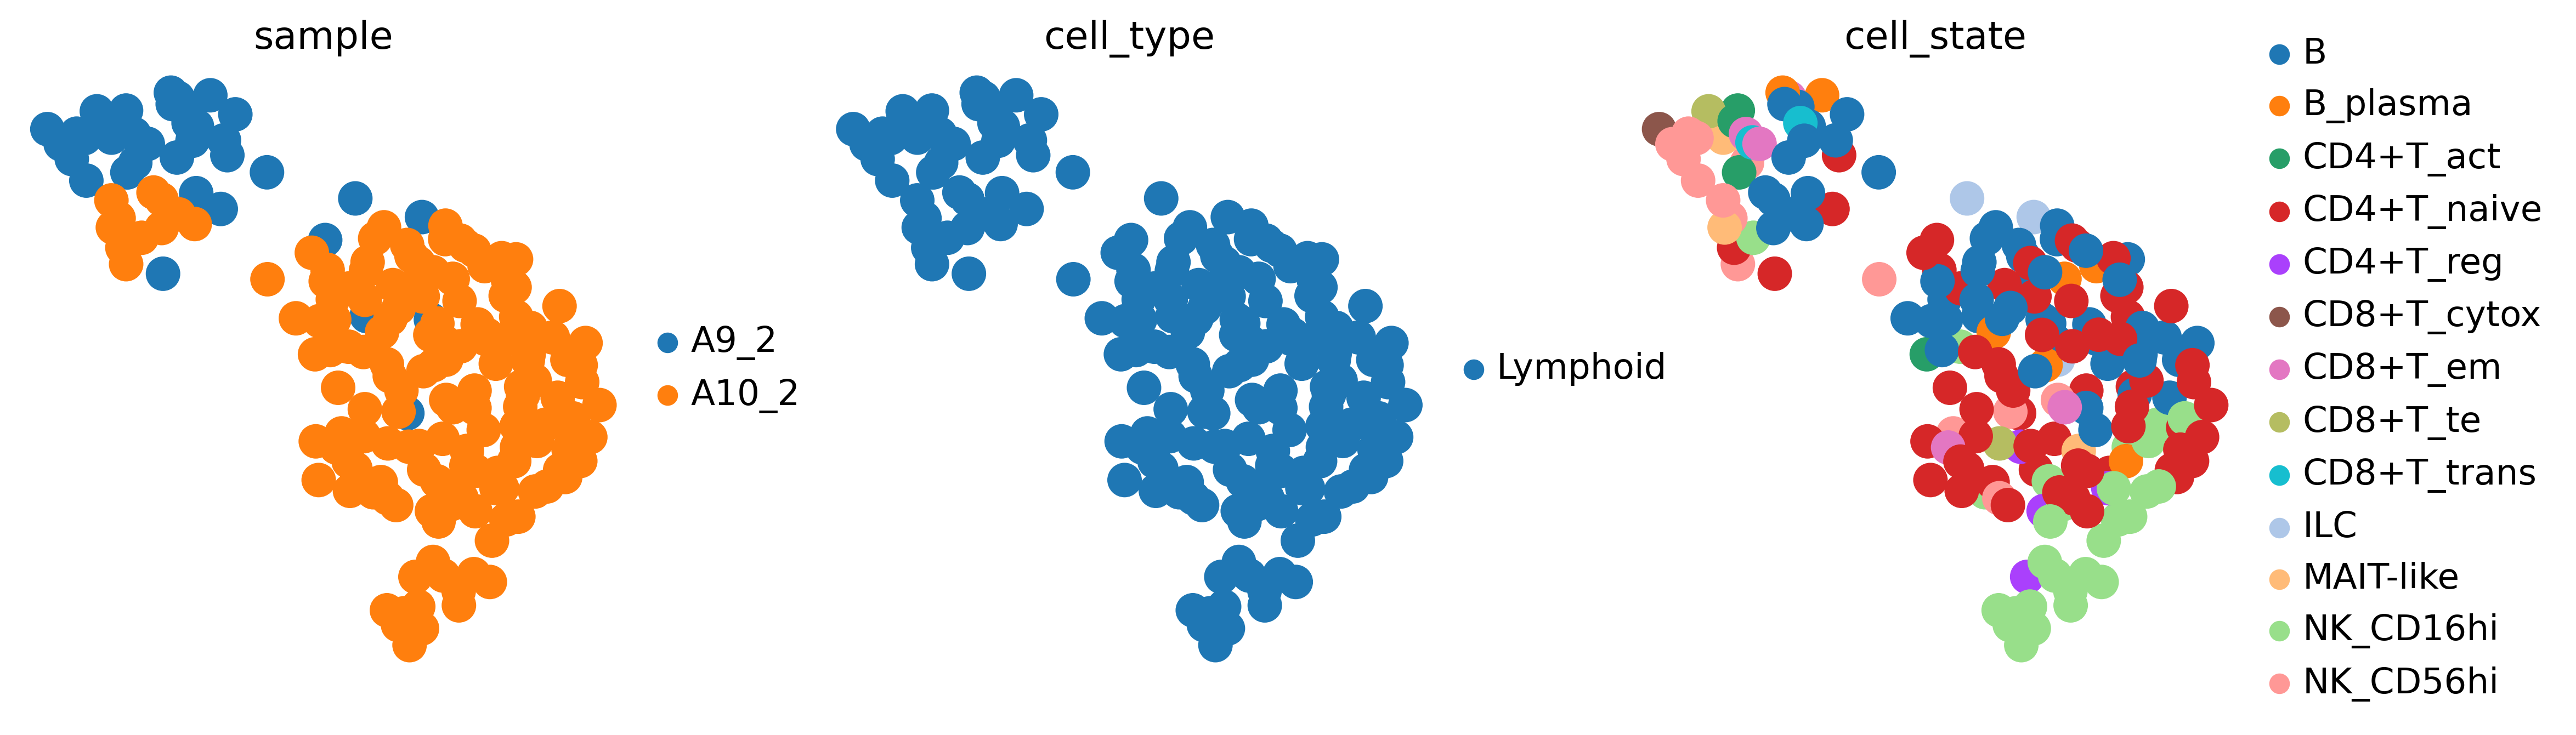

In [917]:
sc.pp.pca(query_export)
sc.pp.neighbors(query_export)
sc.tl.umap(query_export)
sc.pl.umap(query_export, color = ['sample', 'cell_type','cell_state' ], frameon = False)

In [918]:
query_export.write(f'../../data/dmd_annotated_lymphoid_wt_{timestamp}.h5ad')

# SCIB metrics

In [919]:
adata

AnnData object with n_obs × n_vars = 986 × 5235
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query', 'n_cells

In [920]:
scib = scib_metrics.benchmark.Benchmarker(adata, batch_key = 'sample', label_key ='C_scANVI' , embedding_obsm_keys = ['X_scVI', 'X_scANVI','X_pca'])

In [921]:
scib.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:00)


Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

INFO     CD4+T_Th1 consists of a single batch or is too small. Skip.                                               
INFO     CD4+T_reg consists of a single batch or is too small. Skip.                                               


Embeddings:  33%|███▎      | 1/3 [00:04<00:09,  4.67s/it]

INFO     CD4+T_Th1 consists of a single batch or is too small. Skip.                                               
INFO     CD4+T_reg consists of a single batch or is too small. Skip.                                               


Embeddings:  67%|██████▋   | 2/3 [00:06<00:02,  2.99s/it]

INFO     CD4+T_Th1 consists of a single batch or is too small. Skip.                                               
INFO     CD4+T_reg consists of a single batch or is too small. Skip.                                               


Embeddings: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


In [922]:
scib.get_results()

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_scVI,0.412321,0.374848,0.276931,0.543292,0.427247,0.878083,0.000575,0.425017,0.514424,0.0,0.36362,0.406928,0.389605
X_scANVI,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
X_pca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


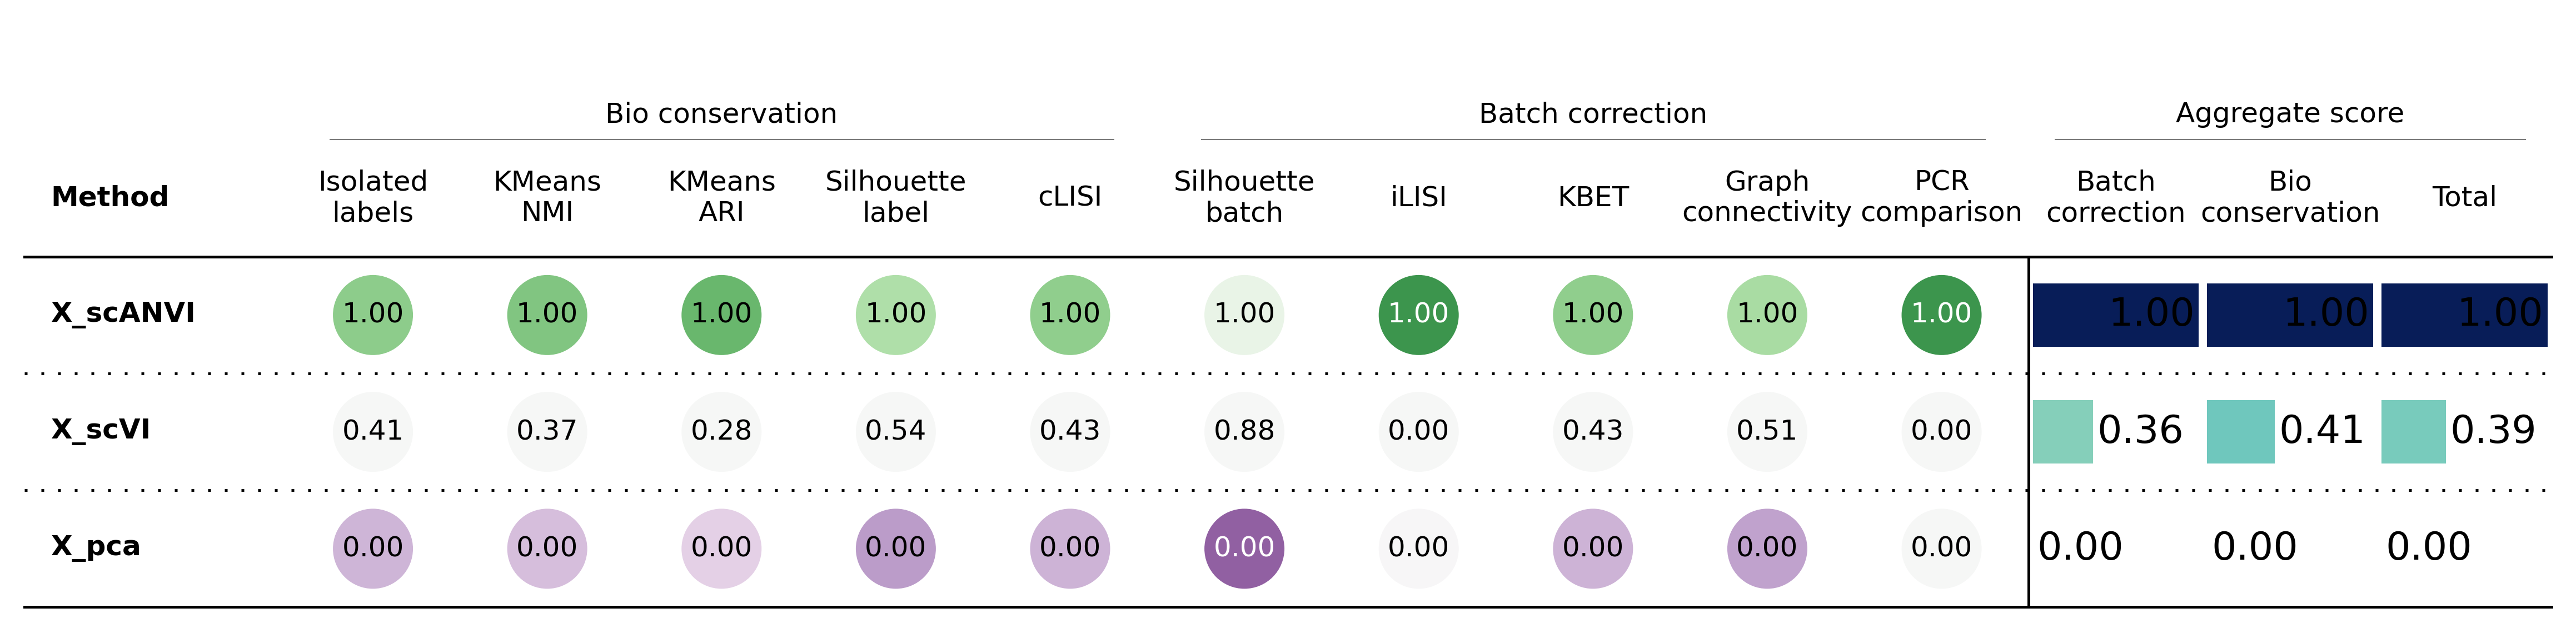

In [923]:
scib.plot_results_table()